In [ ]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from tensorflow.keras.models import Model


import timeit

import warnings
warnings.filterwarnings('ignore')

In [ ]:
batch_size = 32
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28
mnist = mnist = tf.keras.datasets.mnist
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 2s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [ ]:
batch_size = 32
num_classes = 10
epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28
mnist = mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/5
1875/1875 [==============================] - 18s 5ms/step - loss: 0.6509 - accuracy: 0.7818 - val_loss: 0.1027 - val_accuracy: 0.9677
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2961 - accuracy: 0.9066 - val_loss: 0.0679 - val_accuracy: 0.9786
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2377 - accuracy: 0.9265 - val_loss: 0.0594 - val_accuracy: 0.9809
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2091 - accuracy: 0.9352 - val_loss: 0.0527 - val_accuracy: 0.9829
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1962 - accuracy: 0.9392 - val_loss: 0.0479 - val_accuracy: 0.9842


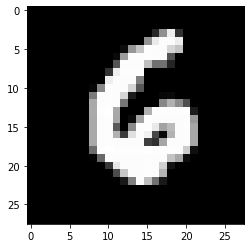

In [ ]:
import pylab as plt

plt.imshow(x_test[130:131].reshape(28,28),cmap='gray')
plt.show()

In [ ]:
import numpy as np
prediction = model.predict(x_test[130:131])
print('Prediction Score:\n',prediction[0])
thresholded = (prediction>0.5)*1
print('\nThresholded Score:\n',thresholded[0])
print('\nPredicted Digit:\n',np.where(thresholded == 1)[1][0])

1/1 [==============================] - 0s 120ms/step
Prediction Score:
 [8.5973390e-08 3.3912098e-09 6.0228351e-09 2.0007268e-10 2.2565440e-05
 2.3241326e-05 9.9988163e-01 1.2714488e-13 7.2455259e-05 7.5955482e-09]

Thresholded Score:
 [0 0 0 0 0 0 1 0 0 0]

Predicted Digit:
 6


In [ ]:
pretrained_model = model

In [ ]:
image_probs = pretrained_model.predict(x_test[130:131])

1/1 [==============================] - 0s 17ms/step


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

In [ ]:
img = x_test[130:131]
tensor1 = tf.convert_to_tensor(img,dtype = tf.float32)

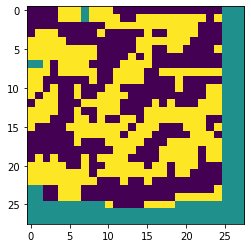

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(tensor1, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);

1/1 [==============================] - 0s 18ms/step

Predicted Digit:
 6


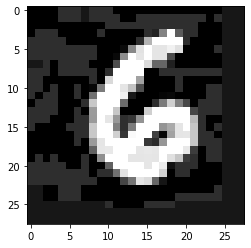

In [ ]:
epsilons = [0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = tensor1 + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  plt.imshow(np.squeeze(adv_x),cmap='gray')
  
  prediction = model.predict((adv_x))
  thresholded = (prediction>0.5)*1
  print('\nPredicted Digit:\n',np.where(thresholded == 1)[1][0])


In [ ]:
print(len(x_train))

60000


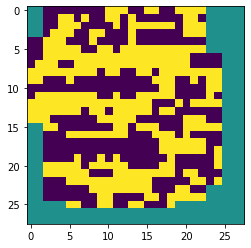

In [ ]:
img = x_train[130:131]
tensor1 = tf.convert_to_tensor(img,dtype = tf.float32)

labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
perturbations = create_adversarial_pattern(tensor1, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);


1/1 [==============================] - 0s 15ms/step

Predicted Digit:
 3


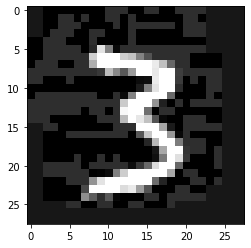

In [ ]:
epsilons = [0.1]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = tensor1 + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  plt.imshow(np.squeeze(adv_x),cmap='gray')
  
  prediction = model.predict((adv_x))
  thresholded = (prediction>0.5)*1
  print('\nPredicted Digit:\n',np.where(thresholded == 1)[1][0])


1/1 [==============================] - 0s 13ms/step


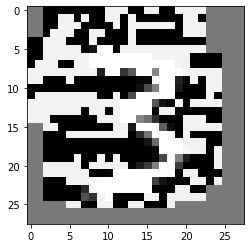

In [ ]:
x_text_new = []
for i in range(100):
  image_probs = pretrained_model.predict(x_train[i:i+1])
  tensor1 = tf.convert_to_tensor(img,dtype = tf.float32)

  labrador_retriever_index = 208
  label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
  label = tf.reshape(label, (1, image_probs.shape[-1]))
  perturbations = create_adversarial_pattern(tensor1, label)
  plt.imshow(perturbations[0] * 0.5 + 0.5);

  epsilons = [0.9]
  descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                  for eps in epsilons]

  for i, eps in enumerate(epsilons):
    adv_x = tensor1 + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    plt.imshow(np.squeeze(adv_x),cmap='gray')

    x_text_new.append(img)
    x_text_new.append(adv_x)


In [ ]:
print(len(x_text_new))


200
